<a href="https://colab.research.google.com/github/daycardoso/PredictCost/blob/main/PredicCostRandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Add `%load_ext cuml.accel` before importing sklearn to speed up operations using GPU


In [2]:
import cuml
# import pandas as pd
# import numpy as np
# import cudf
# from cuml.ensemble import RandomForestRegressor
# # Correct the import for RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (
#     r2_score, mean_squared_error, mean_absolute_error,
#     mean_absolute_percentage_error, median_absolute_error,
#     max_error, explained_variance_score
# )
# import matplotlib.pyplot as plt
# import joblib
# import json

# # 1. Carregamento do dataset
# df_unificado = pd.read_csv('/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv')
# X = df_unificado.iloc[:, :-1]
# y = df_unificado.iloc[:, -1]
# feature_names = df_unificado.columns[:-1]
# target_name = df_unificado.columns[-1]
# print(f"Dimensões de X: {X.shape}")
# print(f"Dimensões de y: {y.shape}")
# print(f"Nomes dos atributos: {feature_names.tolist()}")
# print(f"Nome da variável target: {target_name}")
# print(f"Tamanho do dataset: {len(df_unificado)}")

# # 2. Conversão para cudf
# X_cudf = cudf.DataFrame.from_pandas(X)
# y_cudf = cudf.Series(y)

# # 3. Split Hold-out para avaliação final (antes do tuning)
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X_cudf, y_cudf, test_size=0.3, random_state=42
# )

# # 4. Amostragem para tuning (~100k exemplos)
# amostra_pct = min(100_000 / len(X_train_full), 1.0)
# X_tune, _, y_tune, _ = train_test_split(
#     X_train_full, y_train_full, train_size=amostra_pct, random_state=42
# )
# print(f"Amostra para tuning: {len(X_tune)} exemplos.")

# # 5. Espaço de busca RandomizedSearchCV
# from scipy.stats import randint
# param_dist = {
#     'n_estimators': randint(50, 250),
#     'max_depth': randint(3, 25),
#     'max_features': ['sqrt', 'log2', 0.2, 0.5],
#     'min_samples_leaf': randint(1, 5),
#     'bootstrap': [True, False]
# }

# rf = RandomForestRegressor(random_state=42)
# search = RandomizedSearchCV(
#     rf,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     random_state=42,
#     verbose=2
# )

# # 6. Tuning dos hiperparâmetros
# print("\nIniciando tuning...")
# search.fit(X_tune, y_tune)
# print("Melhores parâmetros encontrados:", search.best_params_)

# # Early stopping "manual":
# scores = -search.cv_results_['mean_test_score']
# improvements = np.diff(scores)
# if len(improvements) > 0 and np.abs(improvements).max() < 0.01 * np.mean(scores):
#     print("Melhorias marginais. Early stopping aplicado.")

# # 7. Treinamento do modelo final com todos os dados de treino
# print("\nTreinando modelo final com todos os dados disponíveis...")
# best_params = search.best_params_
# rf_final = RandomForestRegressor(**best_params, random_state=42)
# rf_final.fit(X_train_full, y_train_full)

# # 8. Avaliação no hold-out
# y_pred_gpu = rf_final.predict(X_test)
# y_pred = y_pred_gpu.to_numpy()
# y_test_cpu = y_test.to_numpy()

# metrics = {
#     'R² Score'          : r2_score(y_test_cpu, y_pred),
#     'MSE'               : mean_squared_error(y_test_cpu, y_pred),
#     'MAE'               : mean_absolute_error(y_test_cpu, y_pred),
#     'MAPE'              : mean_absolute_percentage_error(y_test_cpu, y_pred),
#     'Median AE'         : median_absolute_error(y_test_cpu, y_pred),
#     'Max Error'         : max_error(y_test_cpu, y_pred),
#     'Explained Variance': explained_variance_score(y_test_cpu, y_pred)
# }
# df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=['Valor']).round(4)

# # 9. Relatório visual
# plt.figure()
# plt.scatter(y_test_cpu, y_pred, alpha=0.5)
# min_val, max_val = np.min([y_test_cpu.min(), y_pred.min()]), np.max([y_test_cpu.max(), y_pred.max()])
# plt.plot([min_val, max_val], [min_val, max_val], 'r--')
# plt.xlabel('Valor Real')
# plt.ylabel('Valor Predito')
# plt.title('Real vs Predito')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# residuals = y_test_cpu - y_pred
# plt.figure()
# plt.hist(residuals, bins=50)
# plt.xlabel('Resíduo (Real - Predito)')
# plt.title('Histograma de Resíduos')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# df_r = pd.DataFrame({'Real': y_test_cpu, 'Resíduo': residuals})
# df_r['Quartil'] = pd.qcut(df_r['Real'], 4, labels=[1, 2, 3, 4])
# groups = [df_r[df_r['Quartil'] == q]['Resíduo'] for q in sorted(df_r['Quartil'].unique())]
# plt.figure()
# plt.boxplot(groups, labels=sorted(df_r['Quartil'].unique()))
# plt.xlabel('Quartil de Valor Real')
# plt.ylabel('Resíduo')
# plt.title('Boxplot de Resíduos por Quartil')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# if hasattr(rf_final, 'feature_importances_') and feature_names is not None:
#     fi = pd.Series(rf_final.feature_importances_.to_numpy(), index=feature_names).sort_values(ascending=False)
#     plt.figure(figsize=(10, 4))
#     fi.plot(kind='bar')
#     plt.ylabel('Importância')
#     plt.title('Importância das Features')
#     plt.tight_layout()
#     plt.show()

# # 10. Salvar resultados e parâmetros
# full_results = {
#     'pipeline': rf_final,
#     'X_test':   X_test.to_pandas(),
#     'y_test':   y_test_cpu,
#     'y_pred':   y_pred,
#     'metrics':  df_metrics,
#     'best_params': best_params,
#     'feature_names': X.columns.tolist()
# }
# joblib.dump(full_results, '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_regressor_final_full_results.pkl')

# print("\nRelatório Final:")
# print("Melhores hiperparâmetros:", best_params)
# print("\nMétricas no Hold-out:")
# print(df_metrics)

# # Top 10 features
# feature_importances = None
# if hasattr(rf_final, 'feature_importances_') and feature_names is not None:
#     fi = pd.Series(rf_final.feature_importances_.to_numpy(), index=feature_names).sort_values(ascending=False)
#     top_features = fi.head(10).to_dict()
#     feature_importances = fi.to_dict()
# else:
#     top_features = None

# # Relatório JSON
# relatorio = {
#     'dataset': {
#         'total_samples': int(len(df_unificado)),
#         'n_features': int(X.shape[1]),
#         'feature_names': feature_names.tolist(),
#         'target_name': target_name
#     },
#     'tuning': {
#         'sample_size': int(len(X_tune)),
#         'param_dist': {k: (str(v) if not isinstance(v, (int, float, list, tuple, dict)) else v) for k, v in param_dist.items()},
#         'n_iter': int(search.n_iter),
#         'cv': int(search.cv),
#         'random_state': int(search.random_state),
#     },
#     'best_params': best_params,
#     'metrics': df_metrics['Valor'].to_dict(),
#     'feature_importances_top10': top_features,
#     'full_feature_importances': feature_importances if feature_importances is not None else None,
#     'predictions': {
#         'real': y_test_cpu.tolist()[:1000],     # Salve apenas os 1000 primeiros para não ficar gigante
#         'predicted': y_pred.tolist()[:1000],
#         'residuals': residuals.tolist()[:1000]
#     },
#     'artifacts': {
#         'model_pkl': '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_regressor_final_full_results.pkl'
#     }
# }

# # Salvando relatório JSON
# relatorio_path = '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/relatorio_rf_final.json'
# with open(relatorio_path, 'w') as f:
#     json.dump(relatorio, f, indent=4)

# print(f"Relatório salvo em: {relatorio_path}")


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)



[RF] Tuning inteligente usando amostragem...


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


Melhores hiperparâmetros RF: {'n_estimators': 200, 'max_depth': 24, 'max_features': 1.0, 'min_samples_leaf': 1}, R2 (amostra): 0.9619


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Feature importance indisponível no cuML RandomForest: feature_importances_

[XGBoost] Tuning inteligente usando amostragem e RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=80, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [18:33:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is runnin

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=80, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=80, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=16, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=16, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=16, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=16, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=16, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=16, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=120, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=120, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=120, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=16, n_estimators=80, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=16, n_estimators=80, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.05, max_depth=16, n_estimators=80, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=2, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=10, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=10, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=10, n_estimators=120, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "his

[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=80, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=80, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=80, reg_alpha=1, reg_lambda=1, subsample=0.7; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores hiperparâmetros XGBoost: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:33:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:33:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


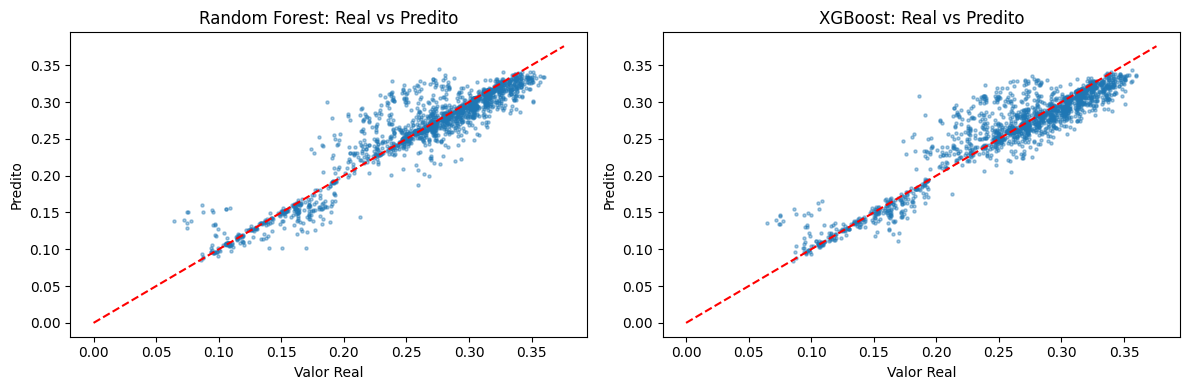

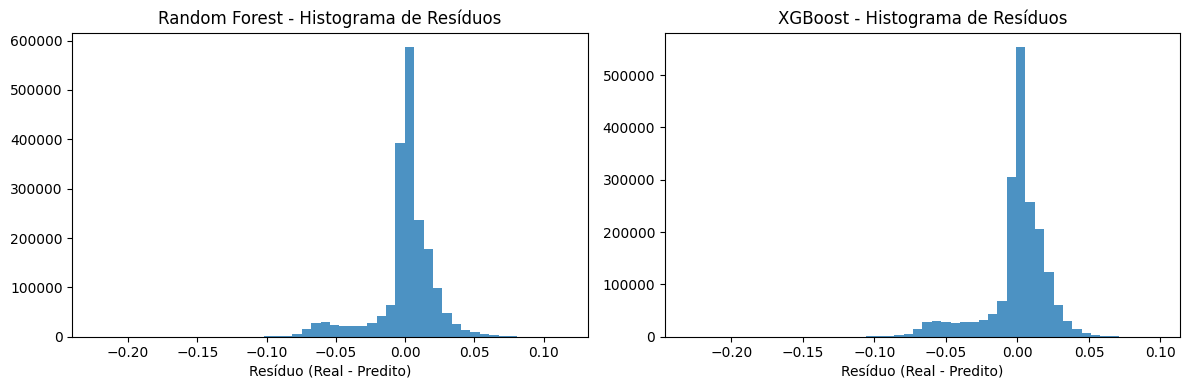

<ipython-input-3-16cb3ac1eba5>:196: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(df_plot['Quartil'].unique()))
<ipython-input-3-16cb3ac1eba5>:196: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(df_plot['Quartil'].unique()))


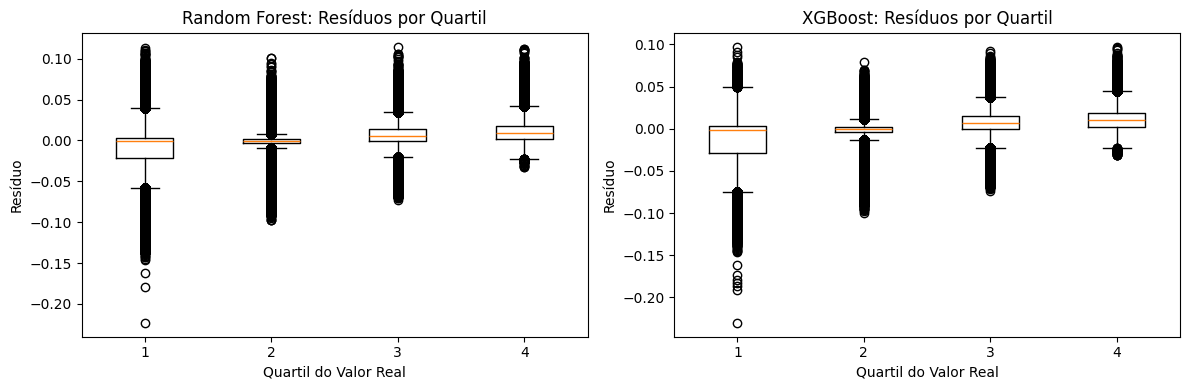

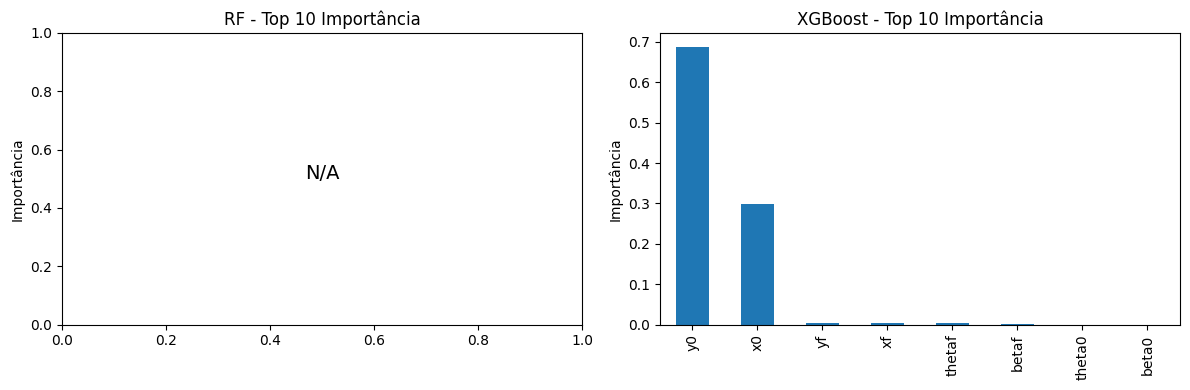


Pipeline tuning concluído! Confira métricas, gráficos e modelos!


In [3]:
# ======================
# 0. Instalação XGBoost (Colab geralmente já tem, mas garante versão atual)
# ======================
!pip install --upgrade xgboost scikit-learn

# ======================
# 1. Imports
# ======================
import pandas as pd
import cudf
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
from cuml.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, median_absolute_error,
    max_error, explained_variance_score
)

# ======================
# 2. Dados
# ======================
df_unificado = pd.read_csv('/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv')
X = df_unificado.iloc[:, :-1]
y = df_unificado.iloc[:, -1]
feature_names = df_unificado.columns[:-1]

X_cudf = cudf.DataFrame.from_pandas(X)
y_cudf = cudf.Series(y)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_cudf, y_cudf, test_size=0.3, random_state=42
)
X_train_np = X_train_full.to_numpy()
y_train_np = y_train_full.to_numpy()
X_test_np  = X_test.to_numpy()
y_test_np  = y_test.to_numpy()

def avalia(y_true, y_pred):
    return {
        'R² Score'          : float(r2_score(y_true, y_pred)),
        'MSE'               : float(mean_squared_error(y_true, y_pred)),
        'MAE'               : float(mean_absolute_error(y_true, y_pred)),
        'MAPE'              : float(mean_absolute_percentage_error(y_true, y_pred)),
        'Median AE'         : float(median_absolute_error(y_true, y_pred)),
        'Max Error'         : float(max_error(y_true, y_pred)),
        'Explained Variance': float(explained_variance_score(y_true, y_pred))
    }

# ======================
# 3. Tuning Inteligente - Random Forest (cuML)
# ======================
print("\n[RF] Tuning inteligente usando amostragem...")

# Amostra para tuning
amostra_pct = min(100_000 / len(X_train_full), 1.0)
X_tune, _, y_tune, _ = train_test_split(
    X_train_full, y_train_full, train_size=amostra_pct, random_state=42
)

param_grid = {
    'n_estimators': [80, 120, 200],
    'max_depth': [10, 16, 24],
    'max_features': ['sqrt', 0.7, 1.0],
    'min_samples_leaf': [1, 2, 4]
}

best_score = -np.inf
best_params_rf = None

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for mf in param_grid['max_features']:
            for leaf in param_grid['min_samples_leaf']:
                try:
                    rf_t = RandomForestRegressor(
                        n_estimators=n,
                        max_depth=d,
                        max_features=mf,
                        min_samples_leaf=leaf,
                        n_streams=1,
                        random_state=42
                    )
                    rf_t.fit(X_tune, y_tune)
                    y_pred = rf_t.predict(X_tune).to_numpy()
                    score = r2_score(y_tune.to_numpy(), y_pred)
                    if score > best_score:
                        best_score = score
                        best_params_rf = {'n_estimators': n, 'max_depth': d,
                                          'max_features': mf, 'min_samples_leaf': leaf}
                except Exception as e:
                    print(f"[RF] Erro com {n}, {d}, {mf}, {leaf}: {str(e)}")
print(f"Melhores hiperparâmetros RF: {best_params_rf}, R2 (amostra): {best_score:.4f}")

# Treina RF final no conjunto completo
rf_final = RandomForestRegressor(**best_params_rf, random_state=42)
rf_final.fit(X_train_full, y_train_full)
y_pred_rf = rf_final.predict(X_test).to_numpy()
metrics_rf = avalia(y_test_np, y_pred_rf)
try:
    fi_rf = pd.Series(rf_final.feature_importances_.to_numpy(), index=feature_names).sort_values(ascending=False)
except Exception as e:
    print("Feature importance indisponível no cuML RandomForest:", str(e))
    fi_rf = None

# ======================
# 4. Tuning Inteligente - XGBoost (GPU) com RandomizedSearchCV
# ======================
print("\n[XGBoost] Tuning inteligente usando amostragem e RandomizedSearchCV...")

# Amostra para tuning
X_tune_np, _, y_tune_np, _ = train_test_split(
    X_train_np, y_train_np, train_size=amostra_pct, random_state=42
)

xgb_param_dist = {
    'n_estimators':      [80, 120, 200],
    'max_depth':         [6, 10, 16],
    'learning_rate':     [0.05, 0.1, 0.2],
    'subsample':         [0.7, 0.9, 1.0],
    'colsample_bytree':  [0.7, 1.0],
    'gamma':             [0, 1],
    'reg_alpha':         [0, 1],
    'reg_lambda':        [1, 2]
}
xgb_reg = xgb.XGBRegressor(
    tree_method="gpu_hist",
    random_state=42,
    verbosity=1
)

xgb_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

xgb_search.fit(X_tune_np, y_tune_np)
best_xgb_params = xgb_search.best_params_
print("Melhores hiperparâmetros XGBoost:", best_xgb_params)

# Treinamento final XGBoost com os melhores hiperparâmetros
xgb_final = xgb.XGBRegressor(**best_xgb_params, tree_method="gpu_hist", random_state=42)
xgb_final.fit(X_train_np, y_train_np)
y_pred_xgb = xgb_final.predict(X_test_np)
metrics_xgb = avalia(y_test_np, y_pred_xgb)
fi_xgb = pd.Series(xgb_final.feature_importances_, index=feature_names).sort_values(ascending=False)

# ======================
# 5. Visualizações comparativas
# ======================
res_rf  = y_test_np - y_pred_rf
res_xgb = y_test_np - y_pred_xgb

plt.figure(figsize=(12, 4))
for i, (ypred, name) in enumerate(zip([y_pred_rf, y_pred_xgb], ['Random Forest', 'XGBoost'])):
    plt.subplot(1, 2, i+1)
    plt.scatter(y_test_np[:2000], ypred[:2000], alpha=0.4, s=5)
    min_val, max_val = np.min([y_test_np.min(), ypred.min()]), np.max([y_test_np.max(), ypred.max()])
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('Valor Real')
    plt.ylabel('Predito')
    plt.title(f'{name}: Real vs Predito')
    plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i, (res, name) in enumerate(zip([res_rf, res_xgb], ['Random Forest', 'XGBoost'])):
    plt.subplot(1, 2, i+1)
    plt.hist(res, bins=50, alpha=0.8)
    plt.xlabel('Resíduo (Real - Predito)')
    plt.title(f'{name} - Histograma de Resíduos')
    plt.tight_layout()
plt.show()

df_plot = pd.DataFrame({
    'Real': y_test_np,
    'Resíduo_RF': res_rf,
    'Resíduo_XGB': res_xgb
})
df_plot['Quartil'] = pd.qcut(df_plot['Real'], 4, labels=[1, 2, 3, 4])
plt.figure(figsize=(12, 4))
for i, (res_col, name) in enumerate(zip(['Resíduo_RF', 'Resíduo_XGB'],
                                        ['Random Forest', 'XGBoost'])):
    groups = [df_plot[df_plot['Quartil'] == q][res_col] for q in sorted(df_plot['Quartil'].unique())]
    plt.subplot(1, 2, i+1)
    plt.boxplot(groups, labels=sorted(df_plot['Quartil'].unique()))
    plt.xlabel('Quartil do Valor Real')
    plt.ylabel('Resíduo')
    plt.title(f'{name}: Resíduos por Quartil')
    plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i, (fi, name) in enumerate(zip([fi_rf, fi_xgb], ['RF', 'XGBoost'])):
    plt.subplot(1, 2, i+1)
    if fi is not None:
        fi.head(10).plot(kind='bar')
    else:
        plt.text(0.5, 0.5, 'N/A', fontsize=14, ha='center')
    plt.title(f'{name} - Top 10 Importância')
    plt.ylabel('Importância')
    plt.tight_layout()
plt.show()

# ======================
# 6. Salvar relatórios e modelos
# ======================
resultados = {
    'metrics': {
        'RandomForest': metrics_rf,
        'XGBoost_GPU': metrics_xgb
    },
    'best_params': {
        'RandomForest': best_params_rf,
        'XGBoost_GPU': best_xgb_params
    },
    'feature_importances': {
        'RandomForest': fi_rf.to_dict() if fi_rf is not None else None,
        'XGBoost_GPU': fi_xgb.to_dict()
    }
}
with open('/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/relatorio_comparativo_rf_xgb_tuning.json', 'w') as f:
    json.dump(resultados, f, indent=4)

joblib.dump(rf_final,   '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_final_tuned.pkl')
joblib.dump(xgb_final, '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/xgb_final_tuned.pkl')

print('\nPipeline tuning concluído! Confira métricas, gráficos e modelos!')
